In [1]:
import netket as nk
import jax
import jax.numpy as jnp
import numpy as np
from time import time
from Models import RestrictedBoltzmannMachine
from itertools import product
from matplotlib import pyplot as plt
from pathlib import Path
import pickle
import json

In [7]:
image_path = Path('./images')
res_path = Path('./Simulations')
jax.devices()

[CpuDevice(id=0)]

In [8]:
n_samples = 3 * 1024
alpha = 4
Sz = 0
lr = 0.08
ds = 0.1
n_iter = 500
n_chains = 32
dL = 10
n_E = 10

In [9]:
L0 = 10
L_list = np.arange(L0, L0 + n_E * dL, dL).tolist()
L_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [10]:
opt_result1 = []
results1 = []
times1 = []

In [9]:
for L in L_list:
    chain_path = f'{res_path}/HeisenbergChain/rbmN{L}' \
                 f'alpha{alpha}{"Sz0" if Sz == 0 else ""}lr{lr}niter{n_iter}n_samples{n_samples}'
    chain = nk.graph.Chain(length=L, pbc=True)
    hilbert = nk.hilbert.Spin(s=1/2, N=L, total_sz=Sz)
    hamiltonian = nk.operator.Heisenberg(hilbert=hilbert, graph=chain, J=1)
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=chain, n_chains=n_chains)
    optimizer = nk.optimizer.Sgd(learning_rate=lr)
    sr = nk.optimizer.SR(diag_shift=ds, holomorphic=True)
    rbm = RestrictedBoltzmannMachine(alpha=alpha, param_dtype=jnp.complex64)
    vstate = nk.vqs.MCState(sampler, rbm, n_samples=n_samples)
    gs = nk.VMC(hamiltonian=hamiltonian, optimizer=optimizer, 
                preconditioner=sr, variational_state=vstate)
    start = time()
    gs.run(out=chain_path, n_iter=n_iter, show_progress=True)
    print(f'L = {L}')
    print(f'Time: {(t := time()-start):.3f} seconds')
    print(f'Computed energy: {(energy := gs.energy.mean.real):.2f}')
    with open(f'{chain_path}.log', 'r') as res:
        rbm_result = json.load(res)
        opt_result1.append(rbm_result['Energy']['Mean']['real'])
    results1.append(energy)
    times1.append(t)

  0%|          | 0/500 [00:00<?, ?it/s]

2024-08-28 10:32:32.747037: W external/xla/xla/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2028077056 bytes.

In [11]:
for L in L_list:
    chain_path = f'{res_path}/HeisenbergChain/rbmN{L}' \
                 f'alpha{alpha}{"Sz0" if Sz == 0 else ""}lr{lr}niter{n_iter}n_samples{n_samples}'
    with open(f'{chain_path}.log', 'r') as res:
        rbm_result = json.load(res)
        opt_result1.append(rbm_result['Energy']['Mean']['real'])
        results1.append(rbm_result['Energy']['Mean']['real'][-1])

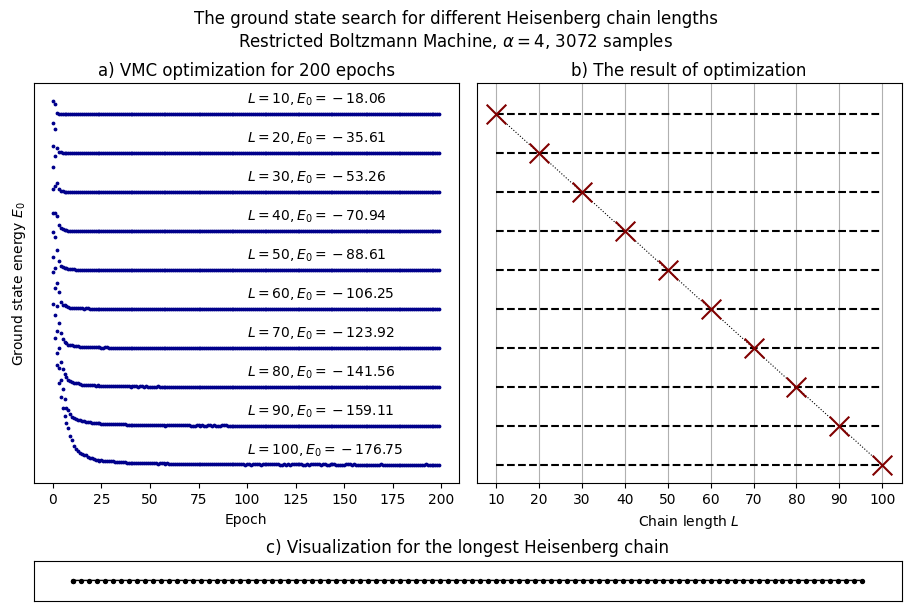

In [12]:
graph = nk.graph.Chain(length=100, pbc=False)
layout = [['A', 'B'], ['C', 'C']]
gridspec_kw = {'width_ratios': [1, 1], 'height_ratios': [10, 1]}
figure, axes = plt.subplot_mosaic(layout, gridspec_kw=gridspec_kw, layout='constrained', figsize=(9, 6))
for L, iterations, energy in zip(L_list, opt_result1, results1):
    its = iterations[0:200]
    axes['A'].scatter(range(len(its)), its, label=f'$\\alpha={alpha}$', s=3, color='darkblue')
    axes['A'].text(int(len(its)/2), energy + 5, f'$L = {L}, E_0 = {energy:.2f}$')
axes['B'].plot(L_list, results1, color='black', linestyle=':', zorder=3, linewidth=0.8)
axes['B'].hlines(results1, L_list[0], L_list[-1], color='black', linestyle='--')
axes['B'].scatter(L_list, results1, color='maroon', marker='x', s=200, zorder=5)
axes['B'].set(xticks=L_list, yticks=[], ylim=axes['A'].get_ylim(), xlabel='Chain length $L$', title=f'b) The result of optimization')
# axes[0].grid()
axes['A'].set(yticks=[], title=f'a) VMC optimization for {len(its)} epochs', xlabel='Epoch', ylabel='Ground state energy $E_0$')
axes['B'].grid()
graph.draw(ax=axes['C'], node_color='black', font_color='black', 
                 edge_color='Black', node_size=8, font_size=0)
axes['C'].set(xticks=[], yticks=[], title='c) Visualization for the longest Heisenberg chain')
figure.suptitle(f'The ground state search for different Heisenberg chain lengths\n'
                f'Restricted Boltzmann Machine, $\\alpha = {alpha}$, {n_samples} samples');

In [80]:
figure.savefig(image_path / f'VisualizationL{L_list[-1]}Alpha{alpha}Nsamples{n_samples}.png')